In [6]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import urllib
from PIL import Image

In [7]:
rating_df = pd.read_csv('../data/cleaned/cleaned_user_rating.csv')
rating_df_copy = rating_df.copy()
movies_df = pd.read_csv('../data/cleaned/cleaned_movies_details.csv', usecols=['movie_id', 'title', 'genres', 'overview', 'director', 'stars', 'img_url'])

# Only keep users with >= 5 ratings
user_rating_counts = rating_df_copy['user_id'].value_counts()
users_with_5_or_more_ratings = user_rating_counts[user_rating_counts >= 5].index
rating_df_copy = rating_df_copy[rating_df_copy['user_id'].isin(users_with_5_or_more_ratings)]
rating_df_copy = rating_df_copy.reset_index(drop=True)

# ID to number
rating_df_copy['user_id_number'] = rating_df_copy['user_id'].astype('category').cat.codes.values
rating_df_copy['movie_id_number'] = rating_df_copy['movie_id'].astype('category').cat.codes.values

all_data = rating_df_copy[['user_id_number', 'movie_id_number', 'rating']].values

In [8]:
display(rating_df_copy)
# Build the mappings
number_to_user_id = dict(enumerate(rating_df_copy['user_id'].astype('category').cat.categories))
user_id_to_number = {v: k for k, v in number_to_user_id.items()}
number_to_movie_id = dict(enumerate(rating_df_copy['movie_id'].astype('category').cat.categories))
movie_id_to_number = {v: k for k, v in number_to_movie_id.items()}
# Example: Get user_id_number for a specific user_id
print(user_id_to_number['ur127508339'])
print(movie_id_to_number['tt7737800'])
# Example: Get user_id for a specific user_id_number
print(number_to_user_id[2255])

,user_id,movie_id,rating,user_id_number,movie_id_number
0,ur127508339,tt7737800,8,2255,17394
1,ur150453978,tt7737800,1,2729,17394
2,ur18519281,tt7737800,3,3344,17394
3,ur0806494,tt7737800,7,1270,17394
4,ur36401655,tt7737800,9,5381,17394
...,...,...,...,...,...
174096,ur16161013,tt0062292,8,2952,1504
174097,ur1399158,tt0062292,7,2541,1504
174098,ur15148330,tt0062292,8,2755,1504
174099,ur1793363,tt0158610,9,3253,6653


2255
17394
ur127508339


In [9]:
# We may store an array for user_id <=> user_id_number and other types
def get_movieURL(movie_id):
    return movies_df[movies_df.movie_id == movie_id].img_url.values[0]

In [10]:
class RISMF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, lambda_reg=0.1, n_epochs=10):
        self.train_data = train_data
        self.test_data = test_data
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1
         
        # P, Q's size may be big at first to add new user/film
        self.P = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_users + 100, self.n_factors))
        self.Q = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_movies + 100, self.n_factors))
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def fit(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                # Update P and Q
                self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
                self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break
                
    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])

        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        # Incremental learning using new ratings
        for u, i, r in processed_ratings:
            u, i, r = int(u), int(i), int(r)
            pred = self.pred(u, i)
            error = r - pred
            # Update P and Q
            self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
            self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

    def pred(self, u, i):
        return self.P[u, :].dot(self.Q[i, :].T)
            
    def print_recommendation(self, user_id, number=10):
        recommended_items = self.recommend(user_id_to_number[user_id])
        recommended_items = recommended_items[:number]
        
        urls = []
        for i in range(number):
            recommended_items[i] = number_to_movie_id[recommended_items[i]]
            urls.append(get_movieURL(recommended_items[i]))
            print(recommended_items[i])
        
        print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
        cols = 5 if number > 5 else number
        rows = math.ceil(number/cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
            
        for i, ax in enumerate(axes.flat):
            if i < number:
                ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                fig.tight_layout()
                ax.axis('off')
            else:
                ax.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def loss(self, data):
        L = 0
        for u, i, r in (data):
            u, i = int(u), int(i)
            pred = self.pred(u, i)
            L += (r - pred)**2
        L /= data.shape[0]
        return math.sqrt(L)

In [11]:
def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

tt0387514
tt1405365
tt0104926
tt23623894
tt0101497
tt0098350
tt0096787
tt0055471
tt0047985
tt0030522
Recommended movie(s) for user ur127508339 : ['tt0387514', 'tt1405365', 'tt0104926', 'tt23623894', 'tt0101497', 'tt0098350', 'tt0096787', 'tt0055471', 'tt0047985', 'tt0030522']


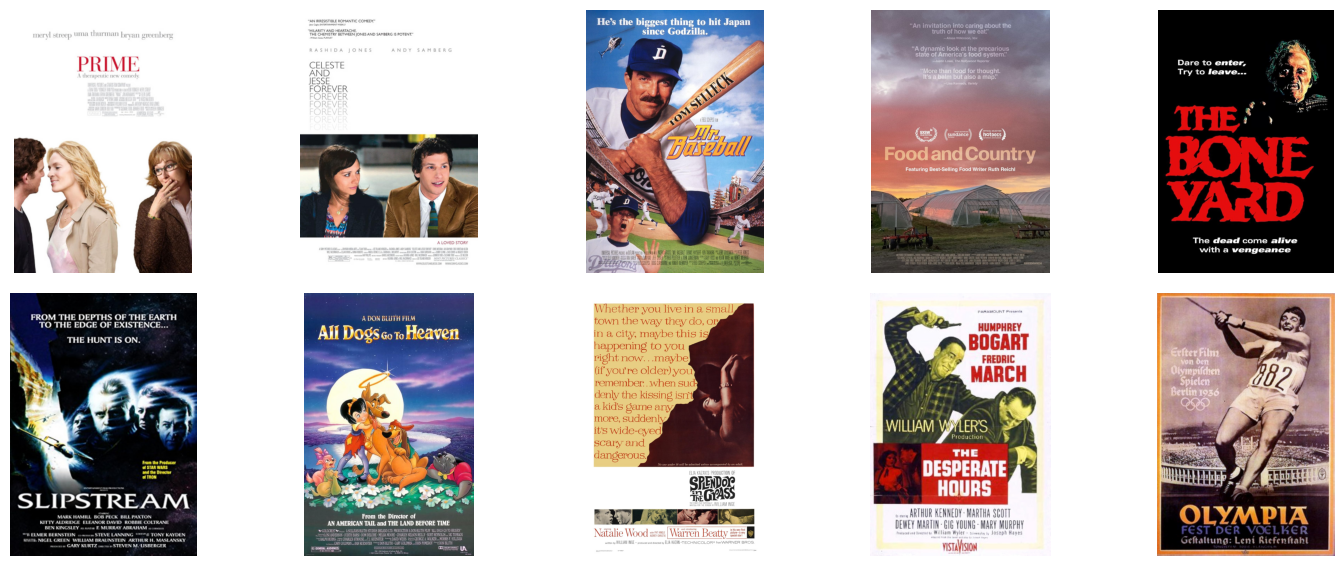

In [20]:
cf_model = load_model("../checkpoints/rismf_nf300_lr0.006.pkl")
cf_model.print_recommendation('ur127508339')